In [1]:
# Setting up by importing all the relevant libraries
import os
import sys
import numpy as np
import cv2
from scipy import misc
import json
import base64
from concurrent.futures.thread import ThreadPoolExecutor

In [49]:
# Define parameters
img_form = r'test_data_prepare\png_from_platform\ProviderFormSample-2.png' 
dict_config = r'Provider_config_base64_improve.json'
out_dir = r'slices'

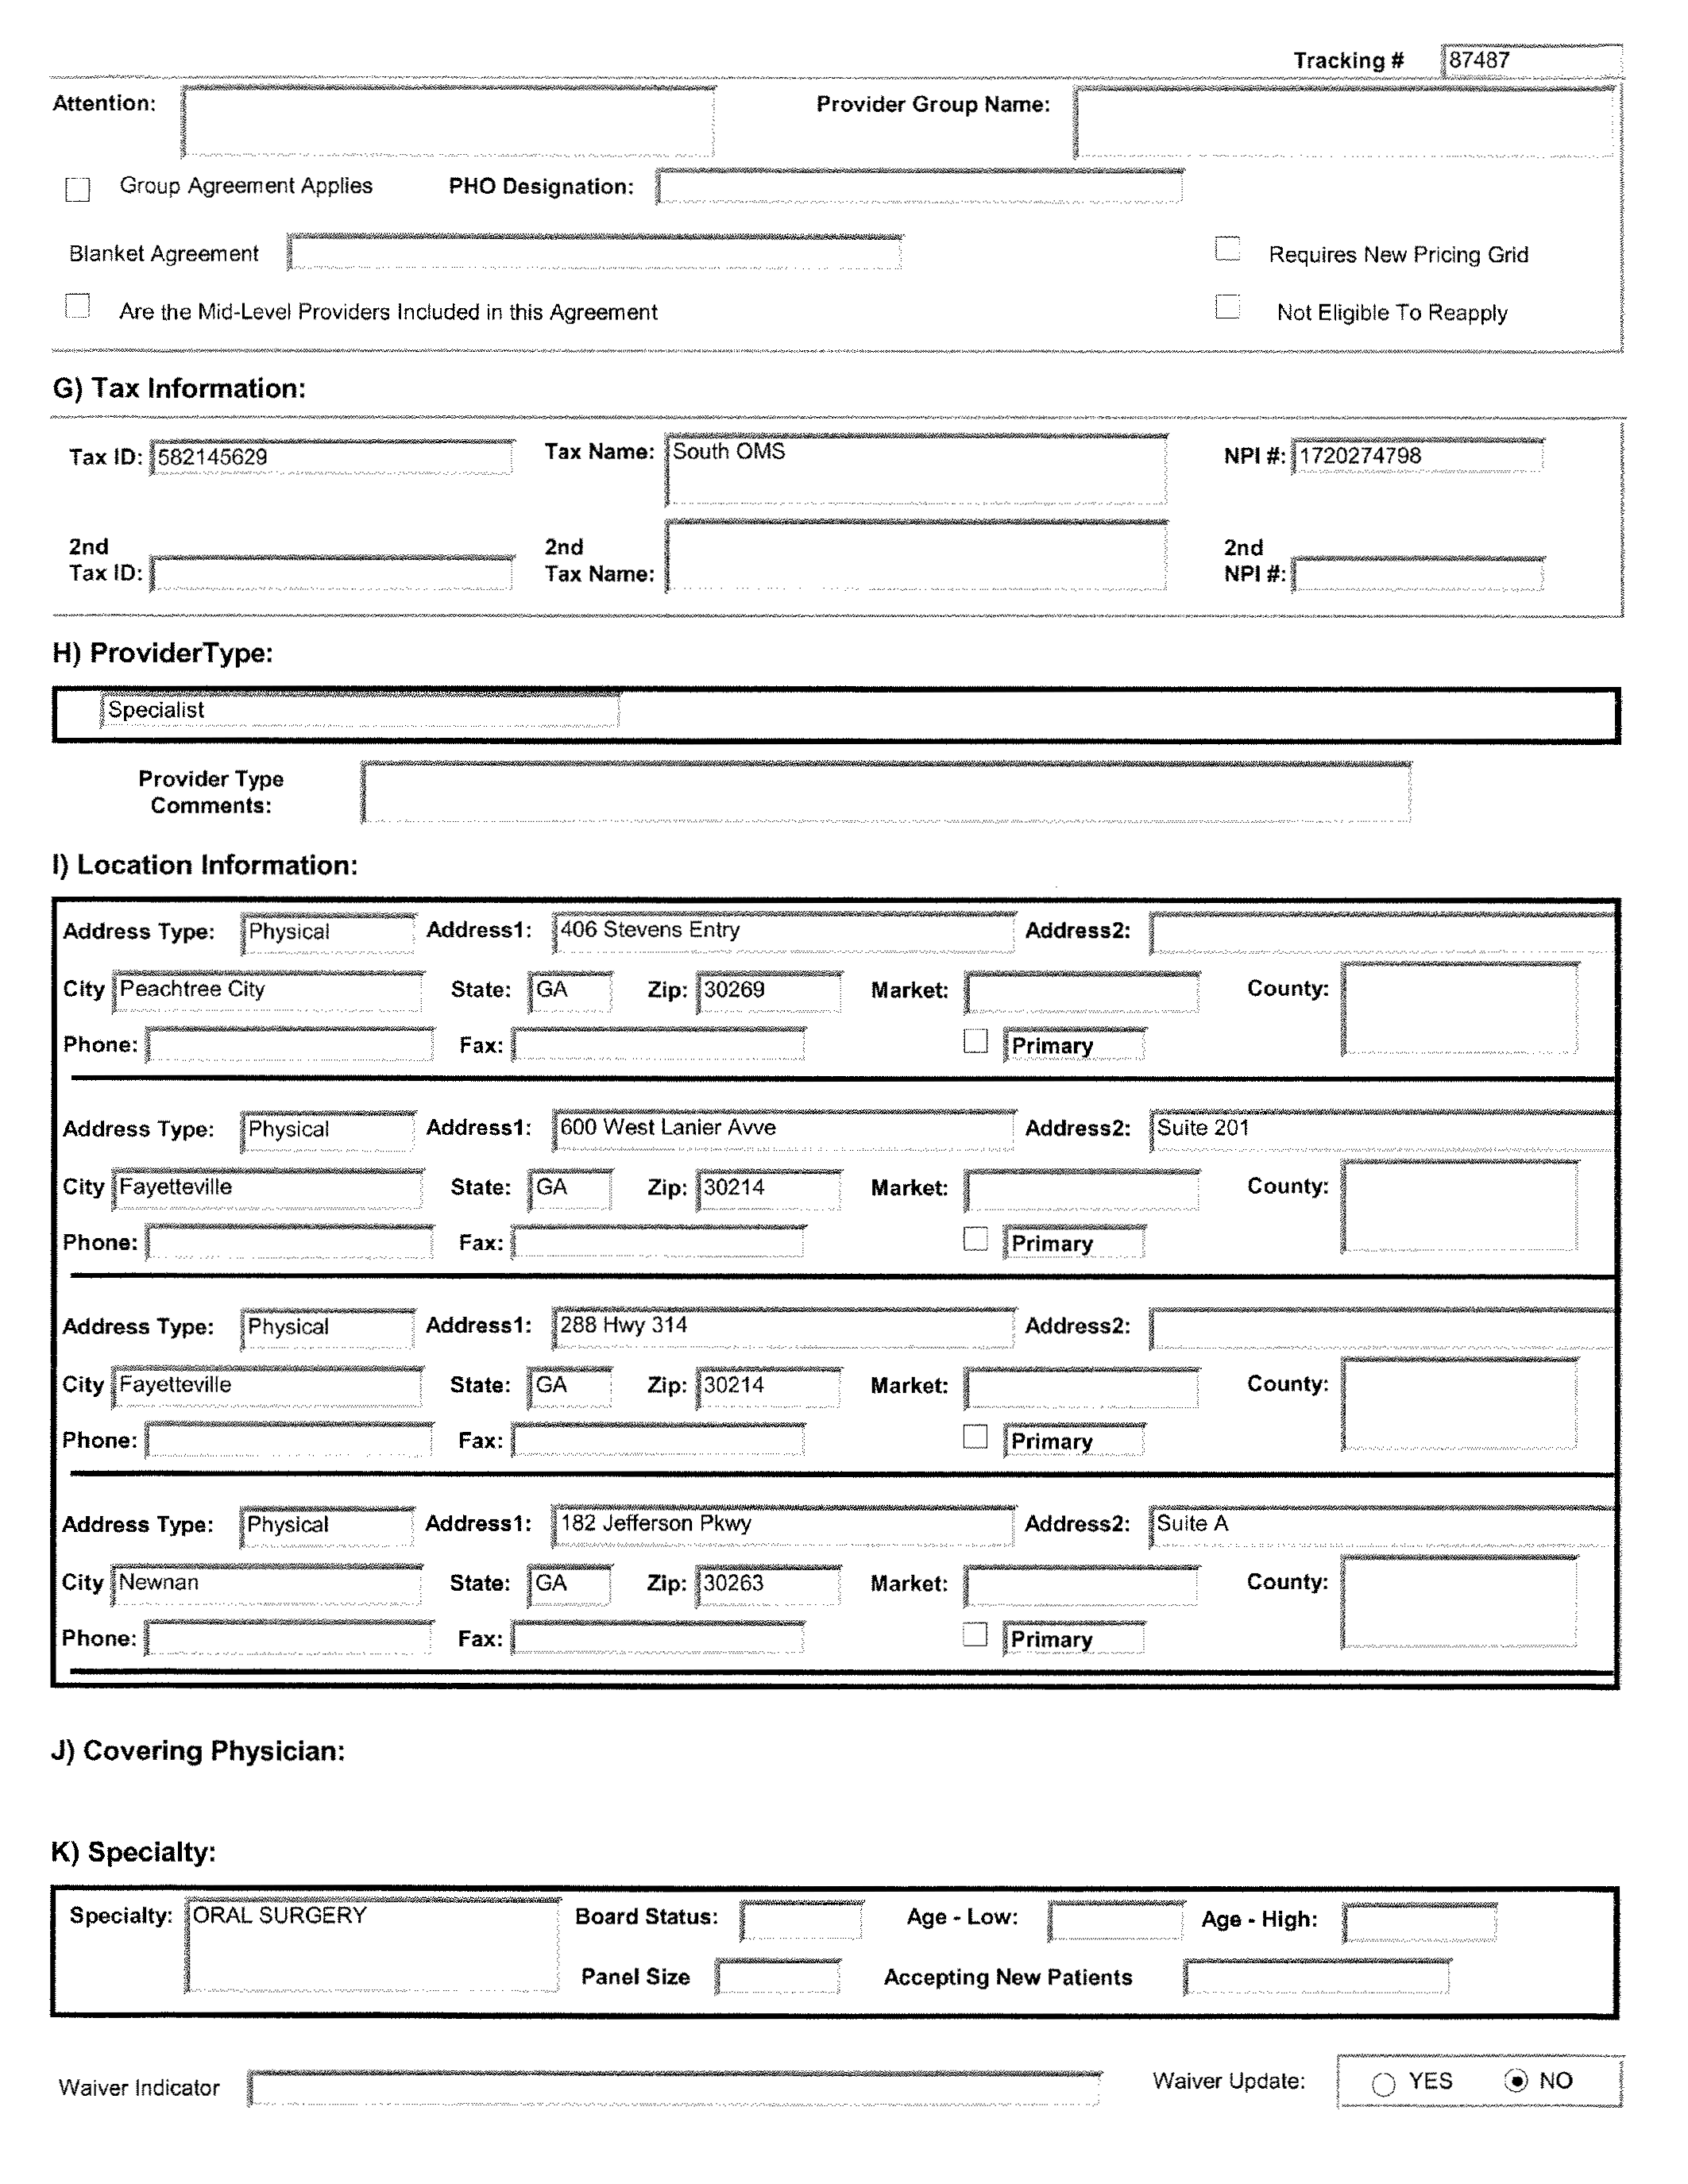

In [61]:
# Loading the form instance as an array
form = cv2.imread(img_form)
misc.toimage(form)
# form_gray = cv2.cvtColor(form,cv2.COLOR_BGR2GRAY)
# form_gray = cv2.GaussianBlur(form_gray,(5,5),0)
# form_gray = form_gray.astype(np.uint8)

In [5]:
# Deskew the form ensure good marker match - NOT USING
flip = cv2.bitwise_not(form_gray)
thresh = cv2.threshold(flip, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
coords = np.column_stack(np.where(thresh > 0))
angle = cv2.minAreaRect(coords)[-1]
# the `cv2.minAreaRect` function returns values in the range [-90, 0); as the rectangle rotates clockwise the
# returned angle trends to 0 -- in this special case we need to add 90 degrees to the angle
if angle < -45:
    angle = -(90 + angle)
# otherwise, just take the inverse of the angle to make it positive
else:
    angle = -angle
# rotate the image to deskew it
(h, w) = form_gray.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(form_gray, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
print (angle)

0.16204825043678284


In [51]:
form.shape

(2750, 2125, 3)

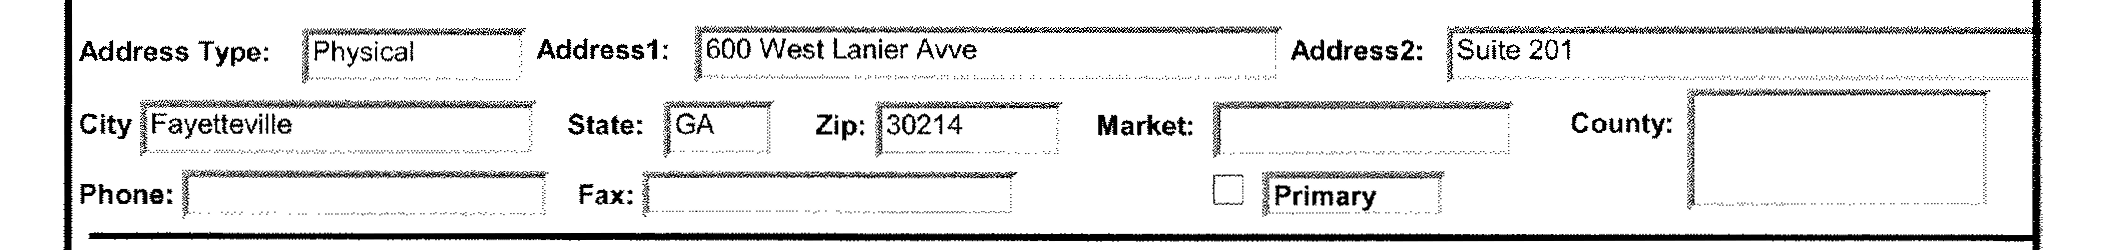

In [62]:
misc.toimage(form[1370:1620,:])

In [63]:
misc.imsave('test_data_prepare\png_from_platform\ProviderFormSample-2_var.png',misc.toimage(np.vstack((misc.toimage(form[:1370,:]),misc.toimage(form[1620:,:])))))

In [13]:
# Loading the coordinate based json configuration file as a python dictionary
with open(dict_config) as config:
    dict_config = json.load(config)

In [14]:
scale_large = 0.8
scale_small = 1.0

key = "Form_Header"
del dict_config[key]

In [15]:
dict_config_keys = ['LocationInfo']

In [20]:
for key in dict_config_keys:
    print ("Extracting form slice for field {}...".format(key))
    temp_image_name = key + '_temp_image.png'
    # Extract reference marker strings
    ref1 = dict_config[key]["ref1_img"]
    # Decode marker to image
    ref1_d = base64.decodebytes(ref1.encode('utf-8'))
    with open(temp_image_name, 'wb') as f:
        f.write(ref1_d)
        f.close()
    img_ref1 = cv2.imread(temp_image_name,0)
    img_ref1 = img_ref1.astype(np.uint8)
    os.remove(temp_image_name)

    # Perform template matching to obtain the best match coordinates & confidence
    large_image = cv2.resize(form_gray,None,fx=scale_large, fy=scale_large, interpolation = cv2.INTER_CUBIC)
    small_image = cv2.resize(img_ref1,None,fx=scale_small, fy=scale_small, interpolation = cv2.INTER_CUBIC)
    result = cv2.matchTemplate(large_image, small_image, cv2.TM_CCOEFF_NORMED)
    _, max_val, _, max_loc = cv2.minMaxLoc(result)
    print (max_val, max_loc)

    if dict_config[key]['type'] in ['tbl','sec']:
        ref2 = dict_config[key]["ref2_img"]
        # Decode marker to image
        ref2_d = base64.decodebytes(ref2.encode('utf-8'))
        with open(temp_image_name, 'wb') as f:
            f.write(ref2_d)
            f.close()
        img_ref2 = cv2.imread(temp_image_name,0)
        img_ref2 = img_ref2.astype(np.uint8)
        os.remove(temp_image_name)

        small_image_ = cv2.resize(img_ref2,None,fx=scale_small, fy=scale_small, interpolation = cv2.INTER_CUBIC)
        result_ = cv2.matchTemplate(large_image, small_image_, cv2.TM_CCOEFF_NORMED)
        _, max_val_, _, max_loc_ = cv2.minMaxLoc(result_)
        print(max_val_, max_loc_)
        #del dict_config[key]["ref2_img"]


    # Define coordinates for slicing for each element type
    # print (max_loc)
    drift = dict_config[key]['drift']
    x1 = int(max_loc[0] / scale_large) + int(drift['x1'] / scale_large)
    x2 = int((max_loc[0] + small_image.shape[1]) / scale_large) + int(drift['x2'] / scale_large)
    y1 = int(max_loc[1] / scale_large) + int(drift['y1'] / scale_large)
    if dict_config[key]['type'] in ['tbl','sec']:
        # print(max_loc_)
        y2 = int((max_loc_[1] + small_image_.shape[0]) / scale_large) + int(drift['y2'] / scale_large)
        confidence = np.mean((max_val, max_val_))
    else:
        y2 = int((max_loc[1] + small_image.shape[0]) / scale_large) + int(drift['y2'] / scale_large)
        confidence = max_val

    if dict_config[key]['type'] in ['sec']:
        section_count = (y2-y1)/(dict_config[key]['y_offset']/scale_large)
        print(section_count)
    # print (rotated.shape, x1, x2, y1, y2)
    slc = misc.toimage(form_gray[y1:y2, x1:x2])

    # Export the slice and update the config file 
    misc.imsave(os.path.join(out_dir, key + '_slice.png'), slc)
    # del dict_config[key]["ref1_img"], dict_config[key]["drift"]
    dict_config[key]["slice_file"] = key + '_slice.png'
    dict_config[key]["slice_xy"] = {"x1": x1, "x2": x2, "y1": y1, "y2": y2}
    dict_config[key]["confidence"] = confidence


Extracting form slice for field LocationInfo...
0.9745414853096008 (50, 5257)
0.978419303894043 (50, 6152)
4.0


In [18]:
slc = cv2.imread(os.path.join(out_dir, key + '_slice.png'),0)
slc.shape

(1000, 1988)

In [1]:
import pytesseract
from PIL import Image
ocr_txt = pytesseract.image_to_string(Image.open("Business_Intent_slice.png"))
print(ocr_txt)


Please terminate provider from Medical contracts only at location, 182 Jefferson Pkwy, Ste A, Newnan, GA 30263. The other locations have been completed
previously. He is remaining active at the locations as NON PAR (load as IDNP) on the Medical side. Correspondence attached


In [2]:
import pytesseract
from PIL import Image
ocr_txt = pytesseract.image_to_string(Image.open("Business_Intent_slice1.png"))
print(ocr_txt)

Please terminate provider from Medical contracts only at location, 182 Jefferson Pkwy. Ste A. Newnan, GA 30263. The other locations have been completed
previously, He is remaining active at the locations as NOK PAR (load as IDNP) on the Medical side, Correspondence attached
